<h1 align="center">PART I</h1>
<h1 align="center">Data Processing and Preparation for Training</h1>

The aim was to process the semantic analysis of English texts, so the collection of positive and negative reviews was taken from [here](http://www.cs.jhu.edu/~mdredze/datasets/sentiment/), this dataset is based on a reviews of various Amazon products.

To get started, install and unzip the archive ([unprocessed.tar.gz](http://www.cs.jhu.edu/~mdredze/datasets/sentiment/unprocessed.tar.gz)) and move the data to the project folder. Now, we import some libraries we need:

In [1]:
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import xml.etree.ElementTree as ET

%matplotlib inline

Also let's write a style for alignment in the middle of all graphs, images, etc:

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

Since we only need files with positive and negative reviews, let's delete the others. And for our negative and positive reviews, we will add a parent tag in which all the reviews will be, so it will be easier to make xml tree. Also, our xml library will complain about the character `&` when parsing, so we will replace it with the word `and`:

In [3]:
import os

for parent, dirnames, filenames in os.walk('sorted_data'):
    for fn in filenames:
        filepath = os.path.join(parent, fn)
        if not (fn.startswith('positive') or fn.startswith('negative')):
            os.remove(filepath)
        else:
            with open(filepath, 'r') as original: data = original.read().replace("&", "and").replace("", "")
            with open(filepath, 'w') as modified: modified.writelines(["<reviews>\n"] + data.splitlines(True)[1:-1] + ["</reviews>"])
            # if you do it for the first time - uncomment line below 
            # with open(filepath, 'w') as modified: modified.writelines(["<reviews>\n"] + data.splitlines(True) + ["</reviews>"])    

print("Remove unnecessary files!\nAdd additional tag to reviews!")

Remove unnecessary files!
Add additional tag to reviews!


Next, since our reviews are in XML format, we need to process each line to get the value from the tags.

**Note**: 
* **`errors='ignore'`** used to skip all possible incorrect characters in our documents;

* **`readLines`** return all lines in the file, as a list where each line is an item in the list object.

In [4]:
test_read = open('sorted_data/music/positive.review', 'r', encoding='utf8', errors='ignore').readlines()
for i in range(10):
    print(test_read[i])

<reviews>

<review><unique_id>

B00008QS9V:it's_a_mighty_wind_a_blowin'!:carla_j._dinsmore_"acoustic_music_junkie"

</unique_id>

<unique_id>

3276

</unique_id>

<asin>

B00008QS9V

</asin>



In our directory with test training sets we have two files - with positive and negative reviews, each of these files contains 1000 unprocessed reviews. Let's check this:

In [5]:
pos_reviews = open('sorted_data/music/positive.review', 'r', encoding='utf8', errors='ignore').read()
neg_reviews = open('sorted_data/music/negative.review', 'r', encoding='utf8', errors='ignore').read()

pos_rev_tree = ET.fromstring(pos_reviews)
neg_rev_tree = ET.fromstring(neg_reviews)

pos_tags = pos_rev_tree.findall('review')
neg_tags = neg_rev_tree.findall('review')

print('\nNumber of Positive Reviews (Music):', len(pos_tags),
      '\nNumber of Negative Reviews (Music):', len(neg_tags))


Number of Positive Reviews (Music): 1000 
Number of Negative Reviews (Music): 1000


**Note:** 
* **`fromstring()`** parses XML from a string directly into an Element, which is the root element of the parsed tree;
* **`findall() `** finds all elements with a tag which are direct children of the current element (`reviews`).

<h2 align="center">XML Parse</h2>

Now we will try to parse our XML file at a basic level. We will create a dictionary from the lists. Each list will contain certain tags and their content for single review. We already have a tree with positive and negative reviews, so all that remains is to parse it. But before that, let's list all the tags in our xml files so we don't have to repeat:

In [6]:
REVIEW_TAGS = ['unique_id', 'asin', 'product_name', 'helpful', 'rating', 'title',
               'date', 'reviewer', 'reviewer_location', 'review_text']

In [7]:
def parseXML(xml_reviews):
    reviews = {}
    count = 0

    for item in xml_reviews:
        count += 1
        rev_name = 'review' + str(count)
        reviews[rev_name] = [
            REVIEW_TAGS[0] + ' | ' + item.find(REVIEW_TAGS[0]).text.strip(),
            REVIEW_TAGS[1] + ' | ' + item.find(REVIEW_TAGS[1]).text.strip(),
            REVIEW_TAGS[2] + ' | ' + item.find(REVIEW_TAGS[2]).text.strip(),
            REVIEW_TAGS[3] + ' | ' + item.find(REVIEW_TAGS[3]).text.strip(),
            REVIEW_TAGS[4] + ' | ' + item.find(REVIEW_TAGS[4]).text.strip(),
            REVIEW_TAGS[5] + ' | ' + item.find(REVIEW_TAGS[5]).text.strip(),
            REVIEW_TAGS[6] + ' | ' + item.find(REVIEW_TAGS[6]).text.strip(),
            REVIEW_TAGS[7] + ' | ' + item.find(REVIEW_TAGS[7]).text.strip(),
            REVIEW_TAGS[8] + ' | ' + item.find(REVIEW_TAGS[8]).text.strip(),
            REVIEW_TAGS[9] + ' | ' + item.find(REVIEW_TAGS[9]).text.strip()
        ]

    return reviews

Now let's actually create dictionaries with the required values and check output:

In [8]:
pos_reviews_dict = parseXML(pos_tags)
neg_reviews_dict = parseXML(neg_tags)
pos_reviews_dict['review1']

['unique_id | B00008QS9V:it\'s_a_mighty_wind_a_blowin\'!:carla_j._dinsmore_"acoustic_music_junkie"',
 'asin | B00008QS9V',
 'product_name | A Mighty Wind: The Album: Music: Various Artists',
 'helpful | ',
 'rating | 5.0',
 "title | It's a Mighty Wind a blowin'!",
 'date | July 5, 2006',
 'reviewer | Carla J. Dinsmore "Acoustic music junkie"',
 'reviewer_location | Wilmington, DE USA',
 'review_text | This is a wonderful album, that evokes memories of the 60\'s folk boom, yet contains original songs. I was amazed at the fantastic harmonies and musical arrangements.\nAnyone who loves the movie "A Mighty Wind" and who loves folk music will fall in love with this album. I know I did']

Next, we will turn our reviews dictionaries into a Pandas DataFrame:

In [9]:
def dict_to_dataframe(reviews_dict):
    # prepare our dataframe for the data
    df = pd.DataFrame(columns=REVIEW_TAGS)
    count = 0
    for val in reviews_dict.values():
        df.loc[count] = [
            val[0].split("|")[1], val[1].split("|")[1],
            val[2].split("|")[1], val[3].split("|")[1],
            val[4].split("|")[1], val[5].split("|")[1],
            val[6].split("|")[1], val[7].split("|")[1],
            val[8].split("|")[1], val[9].split("|")[1]
        ]

        count = count + 1

    return df

pos_music = dict_to_dataframe(pos_reviews_dict)
neg_music = dict_to_dataframe(neg_reviews_dict)

Let's check for correctness:

In [10]:
pos_music.head(n=3)

,unique_id,asin,product_name,helpful,rating,title,date,reviewer,reviewer_location,review_text
0,B00008QS9V:it's_a_mighty_wind_a_blowin'!:carl...,B00008QS9V,A Mighty Wind: The Album: Music: Various Artists,,5.0,It's a Mighty Wind a blowin'!,"July 5, 2006","Carla J. Dinsmore ""Acoustic music junkie""","Wilmington, DE USA","This is a wonderful album, that evokes memori..."
1,B00005JJ04:sometime_tuesday_morning_defies_de...,B00005JJ04,Sometime Tuesday Morning: Music: Johnny A.,4 of 4,5.0,Sometime Tuesday Morning defies description,"May 3, 2005",Tim Withee,"Auburn, WA United States","On one hand, this CD is a straight ahead inst..."
2,"B0002W4SGS:atreyu_jr:hellrun_""dustin""",B0002W4SGS,The Caitiff Choir: Music: It Dies Today,0 of 1,5.0,atreyu JR,"June 12, 2006","hellrun ""dustin""",wisconsin,this band reminds me of the thrill i first go...


In [11]:
neg_music.head(n=3)

,unique_id,asin,product_name,helpful,rating,title,date,reviewer,reviewer_location,review_text
0,"B00004YWGC:what_can_i_say?:ms._aj_""right""",B00004YWGC,Back For The First Time: Music: Ludacris,1 of 13,2.0,What can I say?,"May 4, 2006","Ms. AJ ""Right""","North Carolina, USA",I've always held the philosophy you are what ...
1,B000621498:not_quite_ready_for_prime_time.:g,B000621498,Things Aren't So Beautiful Now: Music: A Thor...,1 of 2,2.0,not quite ready for prime time.,"May 8, 2006",g,san francisco,someone get this band a producer and put them...
2,"B0000AQS1A:disapointment:super_dave_""super_dave""",B0000AQS1A,Chicken N Beer: Music: Ludacris,1 of 2,2.0,Disapointment,"July 1, 2006","Super Dave ""Super Dave""","Knoxville, TN",Tihs Album is not all that good when it came ...


Everything is correct, wonderful! 

And now we will do what we did above, but for a reviews of all categories of Amazon datasets:

In [12]:
pos_reviews, neg_reviews = [], []
counter = 0 # for styled output 

for parent, dirnames, filenames in os.walk('sorted_data'):
    for fn in filenames:
        filepath = os.path.join(parent, fn)
        if counter % 2 == 0: print("—" * 60)
        
        if fn == "positive.review":
            pos_rev_tree = ET.fromstring(open(filepath, 'r').read())
            pos_tags = pos_rev_tree.findall('review')
            pos_reviews.append(parseXML(pos_tags))
            counter += 1
            print("| Parse", filepath.center(50), "|")
        
        if fn == "negative.review":
            neg_rev_tree = ET.fromstring(open(filepath, 'r').read())
            neg_tags = neg_rev_tree.findall('review')
            neg_reviews.append(parseXML(neg_tags))
            counter += 1
            print("| Parse", filepath.center(50), "|")

print("—" * 60, "\n\n!!! Reviews parsing completed successfully !!!")

————————————————————————————————————————————————————————————
| Parse        sorted_data\apparel\negative.review         |
| Parse        sorted_data\apparel\positive.review         |
————————————————————————————————————————————————————————————
| Parse       sorted_data\automotive\negative.review       |
| Parse       sorted_data\automotive\positive.review       |
————————————————————————————————————————————————————————————
| Parse          sorted_data\baby\negative.review          |
| Parse          sorted_data\baby\positive.review          |
————————————————————————————————————————————————————————————
| Parse         sorted_data\beauty\negative.review         |
| Parse         sorted_data\beauty\positive.review         |
————————————————————————————————————————————————————————————
| Parse         sorted_data\books\negative.review          |
| Parse         sorted_data\books\positive.review          |
————————————————————————————————————————————————————————————
| Parse     sorted_data\

<h3 align="center">Data to Pandas Dataframe</h3>

We now have parsed positive and negative reviews for 25 different categories, so let's check this:

In [13]:
print("Number of Positive Categories:", len(pos_reviews), 
    "\nNumber of Negative Categories:", len(neg_reviews))

print("\nNumber of Positive Reviews (Automotive Category):", len(pos_reviews[1]), 
      "\nNumber of Negative Reviews (Books Category):", len(neg_reviews[4]))

Number of Positive Categories: 25 
Number of Negative Categories: 25

Number of Positive Reviews (Automotive Category): 584 
Number of Negative Reviews (Books Category): 1000


Now, we will turn our reviews dictionaries in each category into a Pandas DataFrame:

**Note:** `pd.concat` - Concatenate pandas objects along a particular axis with optional set logic along the other axes.

In [14]:
positive_df, negative_df = pd.DataFrame(columns=REVIEW_TAGS), pd.DataFrame(columns=REVIEW_TAGS)

In [15]:
for review in pos_reviews:
    print(review['review1'], '\n')
    df = dict_to_dataframe(review)
    positive_df = pd.concat([positive_df, df])
    df.empty

['unique_id | B0007QCQA4:good_sneakers:christopher_w._damico_"macman"', 'asin | B0007QCQA4', "product_name | adidas Originals Men's Superstar II Basketball Shoe: Apparel", 'helpful | 0 of 1', 'rating | 4.0', 'title | GOOD SNEAKERS', 'date | July 15, 2006', 'reviewer | Christopher W. Damico "MACMAN"', 'reviewer_location | NYC', "review_text | GOOD LOOKING KICKS IF YOUR KICKIN IT OLD SCHOOL LIKE ME. AND COMFORTABLE. AND RELATIVELY CHEAP. I'LL ALWAYS KEEP A PAIR OF STAN SMITH'S AROUND FOR WEEKENDS"] 

['unique_id | B0009N4F6I:works_very_well:i_have_9_cats', 'asin | B0009N4F6I', 'product_name | Wedgie Cup Holder: Automotive', 'helpful | 1 of 1', 'rating | 5.0', 'title | Works very well', 'date | August 19, 2006', 'reviewer | I have 9 cats', 'reviewer_location | Dela where?', "review_text | I bought one today for my Mazda Tribute because I didn't like the built-in cup holders. It's actually very sturdy and fits very well."] 

['unique_id | B0002U1SFE:love_it!:a._kurczewski', 'asin | B0002U1

['unique_id | B00008SCFU:fast_and_accurate:j._n._fong', 'asin | B00008SCFU', 'product_name | Kingston 256 MB Secure Digital Card ( SD/256 ): Electronics', 'helpful | ', 'rating | 5.0', 'title | Fast and Accurate', 'date | March 19, 2006', 'reviewer | J. N. Fong', 'reviewer_location | Castro Valley, CA  USA', "review_text | I received my Kingston 256MB SD card just as advertised.\nThe unit came in the mail exactly 2 days after I\nordered. Worked perfectly and I'm very satisfied"] 

['unique_id | B0000TVVEA:an_excellent_italian_gift_basket._.,:stewart__l', 'asin | B0000TVVEA', 'product_name | Italian Gift Basket - Classic (3.8 Pound) by igourmet.com: Gourmet Food', 'helpful | 5 of 11', 'rating | 5.0', 'title | An excellent italian gift basket. .,', 'date | November 24, 2005', 'reviewer | stewart  L', 'reviewer_location | flushing ,ny', 'review_text | This italian gift basket,captures the feeling of italy,at it best...When you send this to family or friends,they will definitly,feel the lo

['unique_id | B00024J7C6:which_is_the_biggest_monster:man_from_u.k._"inside_canon"', 'asin | B00024J7C6', 'product_name | Toilet Monster: Sports andamp; Outdoors', 'helpful | 14 of 22', 'rating | 5.0', 'title | Which is the biggest monster', 'date | January 30, 2006', 'reviewer | Man From U.K. "Inside Canon"', 'reviewer_location | MD USA', "review_text | This monster is great...my old millionaire nan came over recently to tell us that she was about to take us out of her will because we had too much money already, and as luck would have it she had to use the bathroom during that same visit. We heard this scream from the bathroom and when we broke in we found our nan dead on the floor...luckily she hadn't gone to her attorney's office to sign the new will and we got our share after all...thanks toilet monster..you were worth the $15 + $5 shipping we paid for you"] 

['unique_id | B000630AR4:make_life_easier:m._i._guerrero_"sunsad"', 'asin | B000630AR4', 'product_name | Car Wash Wipes: To

In [16]:
for review in neg_reviews:
    df = dict_to_dataframe(review)
    negative_df = pd.concat([negative_df, df])
    df.empty

Let's generate descriptive statistics. Pandas Dataframe descriptive statistics include those that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values. We will also check whether the number of positive and negative reviews has been preserved.

In [17]:
print('\nNumber of Positive Reviews (Dataframe):', len(positive_df),
      '\nNumber of Negative Reviews (Dataframe):', len(negative_df))

positive_df.describe()
negative_df.describe()


Number of Positive Reviews (Dataframe): 21972 
Number of Negative Reviews (Dataframe): 16576


,unique_id,asin,product_name,helpful,rating,title,date,reviewer,reviewer_location,review_text
count,16576,16576,16576,16576,16576,16576,16576,16576,16576,16576
unique,15442,10905,10773,908,2,13330,1664,13427,5736,14726
top,"B0000AFQQU:this_is_a_big,_glossy_brochure_for...",B00099QAQK,TIME [6-month subscription] [with $5 Bonus]: ...,,1.0,Disappointed,"January 9, 2007",,,This was my first download of this type and a...
freq,4,18,20,2748,10443,79,216,452,3572,18


Actually, `unique_id` has the same information as tags `asin`, `title` and `reviewer` so we can remove it:

In [18]:
positive_df.drop('unique_id', axis=1, inplace=True)
negative_df.drop('unique_id', axis=1, inplace=True)

We will also add a new column `Class`, which will have the value of either `pos` or `neg`, it is necessary to distinguish between positive and negative reviews after concatenation.

In [19]:
positive_df['Class'] = "pos" # positive reviews
negative_df['Class'] = "neg" # negative reviews

reviews = pd.concat([positive_df, negative_df])

Let's see what we got:

In [20]:
reviews.head(n=2)

,asin,product_name,helpful,rating,title,date,reviewer,reviewer_location,review_text,Class
0,B0007QCQA4,adidas Originals Men's Superstar II Basketbal...,0 of 1,4.0,GOOD SNEAKERS,"July 15, 2006","Christopher W. Damico ""MACMAN""",NYC,GOOD LOOKING KICKS IF YOUR KICKIN IT OLD SCHO...,pos
1,B0002Y2JYY,Elite Metal Aviator Sunglasses with Mirror Le...,3 of 5,4.0,Pretty Good,"August 13, 2006","Sharon Civile ""Jackbauerfreak""","Philadelphia, PA",These sunglasses are all right. They were a l...,pos


Let's print the full text of the review (`review_text`) for the text with id 1:

In [21]:
reviews.iloc[0, 8]

" GOOD LOOKING KICKS IF YOUR KICKIN IT OLD SCHOOL LIKE ME. AND COMFORTABLE. AND RELATIVELY CHEAP. I'LL ALWAYS KEEP A PAIR OF STAN SMITH'S AROUND FOR WEEKENDS"

Now our work with the formation of datasets is complete, let's move on.

<h2 align="center">NLTK (Natural Language Toolkit)</h2>

NLTK is a leading platform for building Python programs to work with human language data. 

It provides easy-to-use interfaces and lexical resources such as WordNet, along with a suite of text processing libraries for classification, tokenization, stemming, tagging, parsing, and semantic reasoning.

**Note:** 
- **`word_tokenize`** - extract words from the text;
- **`sent_tokenize`** - extract sentences from the text.

In [23]:
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer

def word_sent_tokenize(sent):
    return word_tokenize(sent), sent_tokenize(sent)

# also at this method we will bring the words to lowercase to make it easier to work with them
def regex_tokenizer(sent):
    return RegexpTokenizer(r'\w+').tokenize(sent.lower())

words, sents = word_sent_tokenize(reviews.iloc[3, 8])
print("\tReview ID4 - Words:\n", words, "\n\n\tReview ID4 - Sentences:\n", sents)

	Review ID4 - Words:
 ['Very', 'nice', 'basic', 'clothing', '.', 'I', 'think', 'the', 'size', 'is', 'fine', '.', 'I', 'really', 'like', 'being', 'able', 'to', 'find', 'these', 'shades', 'of', 'green', ',', 'though', 'I', 'have', 'decided', 'the', 'lighter', 'shade', 'is', 'really', 'a', 'feminine', 'color', '.', 'This', 'is', 'the', 'only', 'brand', 'that', 'I', 'can', 'find', 'these', 'muted', 'greens'] 

	Review ID4 - Sentences:
 [' Very nice basic clothing.', 'I think the size is fine.', 'I really like being able to find these shades of green, though I have decided the lighter shade is really a feminine color.', 'This is the only brand that I can find these muted greens']


<h3 align="center">StopWords Elimination</h3>

We will take stopwords from the NLTK library:

In [24]:
from nltk.corpus import stopwords

STOP_WORDS = set(stopwords.words("english"))

In [25]:
def stopwords_elimination(stop_words, sent):
     return [w.lower() for w in sent if w.lower() not in stop_words]


filtered_words = stopwords_elimination(STOP_WORDS, words)

print("\n======================== STOP WORDS ========================\n", STOP_WORDS,
      "\n\n==================== WORDS FROM REVIEW 4 ====================\n", words,
      "\n\n================== FILTERED WORDS REVIEW 4 ==================\n", filtered_words)


======================== STOP WORDS ========================
 {'in', 'about', 'once', 'hers', "hadn't", "don't", 'y', 'by', 'after', 'below', 'wasn', 'but', 'have', 'mightn', "it's", 'ourselves', 'an', "hasn't", "won't", 'themselves', 't', 'off', 'can', 'them', 'aren', 'doing', "wouldn't", 'our', "you're", 'haven', 'further', 'yourself', 'and', 'her', "mustn't", 'should', 'll', 'you', 'what', 'all', 'ours', 'until', 'his', 'from', 'i', 'for', "that'll", 'under', 'too', 'didn', 'ma', 'she', 'the', 'or', 'to', 'doesn', 'him', "shan't", "aren't", 's', "mightn't", 'each', 'couldn', 'm', 'are', "doesn't", "didn't", "wasn't", 'we', 'while', 'between', 'than', 'out', 'whom', 'before', 'd', 'isn', 'myself', 'yours', 'here', 'of', 'was', "you've", 'will', 'most', 'such', 've', 'into', 'your', 'because', 'itself', 'through', "weren't", 'its', 'been', 'theirs', 'it', 'their', 'needn', 'these', 'ain', 'did', 'me', 'only', 'then', 'up', 'hasn', 'does', 'do', 'no', 'against', 'won', 'not', 'were', 

<h4 align="center">StopWords WordCloud Visualization</h4>

Next, let's visualize using the WordCloud library:

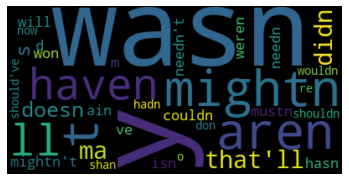

In [26]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud().generate(' '.join(STOP_WORDS))

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

<h3 align="center">Stemming</h3>

For grammatical purposes, documents are going to use various forms of a word, such as `running`, `runs`, `runned`. In certain cases, it appears that it would be useful for a search for one of these words to return documents that contain another word in the set. Both stemming and lemmatization have the aim of reducing a word's inflectional and often derivationally related forms to a common base form.

**Stamming** is the process of shortening a word to the base by discarding auxiliary parts, such as endings or suffixes. The results of stemming are sometimes very similar to determining the root of a word, but its algorithms are based on other principles. Therefore, the word after processing by the algorithm of steming (stematization) may differ from the morphological root of the word.

*Example*: 

*`running`*, *`runs`*, *`runned`* → **`run`**

We would use `PorterStemmer` from `nltk.stem` for our stemming:

In [27]:
from nltk.stem import PorterStemmer

def stem_words(words):
    return [PorterStemmer().stem(word) for word in words]

stemmed_words = stem_words(filtered_words)
print(stemmed_words)

['nice', 'basic', 'cloth', '.', 'think', 'size', 'fine', '.', 'realli', 'like', 'abl', 'find', 'shade', 'green', ',', 'though', 'decid', 'lighter', 'shade', 'realli', 'feminin', 'color', '.', 'brand', 'find', 'mute', 'green']


<h3 align="center">Lemmatizing</h3>

<cite><b>Lemmatization</b>, unlike <b>Stemming</b>, reduces the inflected words properly ensuring that the root word belongs to the language. In Lemmatization root word is called <b>Lemma</b>. A lemma is the canonical form, dictionary form, or citation form of a set of words.</cite>

At lematization the word loses inflectional endings and finds the basic form. For example, `[bats — bat]`, `[feet — foot]`, `[mice — mouse]`.

Python `NLTK` provides `WordNet Lemmatizer` that uses the `WordNet Database` to lookup lemmas of words.

Let's connect the library and see how it works:

In [28]:
from nltk.stem import WordNetLemmatizer

def lemmatize_words(words):
    return [WordNetLemmatizer().lemmatize(word) for word in words]

lemmatized_words = lemmatize_words(filtered_words)
print(lemmatized_words)

['nice', 'basic', 'clothing', '.', 'think', 'size', 'fine', '.', 'really', 'like', 'able', 'find', 'shade', 'green', ',', 'though', 'decided', 'lighter', 'shade', 'really', 'feminine', 'color', '.', 'brand', 'find', 'muted', 'green']


<h2 align="center">Processing of All Reviews</h2>

Now let's start processing all reviews using the methods described above. Lematization is quite a time-consuming procedure, so you have to wait:

In [29]:
# Use regex_tokenizer to get rid of punctuation
words_list = [regex_tokenizer(item) for item in list(reviews['review_text'])]
print("Review without punctuation: ", words_list[1])

# Eliminate stopwords
words_list = [stopwords_elimination(STOP_WORDS, word) for word in words_list]
print("\n\nReview after stopwords elimination: ", words_list[1])

# Lemmatizing
words_list = [lemmatize_words(word) for word in words_list]
print("\n\nReview after lemmatizing: ", words_list[1])

Review without punctuation:  ['these', 'sunglasses', 'are', 'all', 'right', 'they', 'were', 'a', 'little', 'crooked', 'but', 'still', 'cool']


Review after stopwords elimination:  ['sunglasses', 'right', 'little', 'crooked', 'still', 'cool']


Review after lemmatizing:  ['sunglass', 'right', 'little', 'crooked', 'still', 'cool']


<h3 align="center">Transition from multidimensional array to one-dimensional</h3>

In [30]:
from nltk import FreqDist

all_words = np.concatenate(words_list)

all_words_freq = FreqDist(all_words) # count the number of times that each outcome of an experiment occurs
    
print("Most popular words: ", all_words_freq.most_common(100))
print("\nTotal number of unique words: ", len(all_words_freq.keys()))

Most popular words:  [('one', 19296), ('like', 14891), ('time', 12019), ('get', 11957), ('would', 11771), ('great', 11248), ('good', 10940), ('product', 8722), ('use', 8499), ('well', 8117), ('even', 7809), ('also', 7785), ('work', 7738), ('really', 7716), ('make', 7519), ('game', 7505), ('much', 7093), ('year', 6953), ('first', 6669), ('love', 6619), ('movie', 6592), ('book', 6230), ('thing', 5957), ('bought', 5626), ('better', 5435), ('buy', 5355), ('little', 5317), ('way', 5272), ('back', 5270), ('go', 5207), ('2', 5163), ('could', 5052), ('two', 4971), ('still', 4941), ('look', 4918), ('new', 4819), ('day', 4726), ('best', 4645), ('used', 4609), ('take', 4507), ('want', 4506), ('got', 4488), ('film', 4481), ('many', 4479), ('problem', 4436), ('think', 4368), ('camera', 4355), ('see', 4305), ('know', 4276), ('never', 4241), ('say', 4201), ('find', 4137), ('need', 4079), ('magazine', 4065), ('old', 4049), ('made', 4009), ('quality', 3977), ('people', 3946), ('come', 3879), ('price', 

<h3 align="center">Visualization of the most used words</h3>

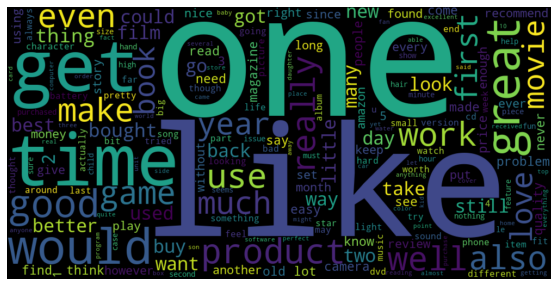

In [31]:
wordcloud = WordCloud(
    background_color="black",
    width=1000,
    height=500,
    random_state=42,
)

wordcloud.generate_from_frequencies(all_words_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

<AxesSubplot:>

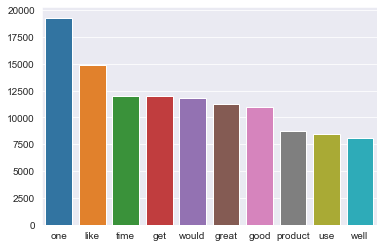

In [32]:
import seaborn as sns
count, words = [], []
for w in all_words_freq.most_common(10):
    words.append(w[0])
    count.append(w[1])

sns.set_style("darkgrid")
sns.barplot(x=words,y=count)

As we can see, we still have a lot of words that are not important in the context (`one`, `get`), this needs to be corrected, so we are writing new methods.

<h3 align="center">Irrelevent Words Elimination</h3>

We will delete all words with a length of less than 3 and numbers. I don't know why, but for one cycle, it doesn't delete all superfluous words therefore it was necessary to put for this purpose a `while` cycle.

In [33]:
from re import match 

def irr_words_elim(words):
    while True:
        ready = True
        
        for word in words:
            if word.isdigit() or len(word) <= 3:
                ready = False
                words.remove(word)
        
        if ready: break
        
    return words

Now actually delete all irrelevant words:

In [34]:
for review in words_list: 
    irr_words_elim(review)

all_words = np.concatenate(words_list)
all_words_freq = FreqDist(all_words)

print("\nTotal number of unique words:", len(all_words_freq))


Total number of unique words: 59837


<h3 align="center">Visualization of the most used words after processing</h3>

Next, let's visualize using the WordCloud library. Also add a little style and make a special mask. So that we can add our own mask for WordCloud, we need to write a method that will allow us to do this, but before that we import the necessary libraries:

In [35]:
import cv2

from urllib.request import urlopen
from wordcloud import ImageColorGenerator

Now, we load simple mask as numpy array:

In [36]:
def load_mask(mask_url):
    with urlopen(mask_url) as response:
        mask = np.asarray(bytearray(response.read()), dtype="uint8")
        mask = cv2.imdecode(mask, cv2.IMREAD_COLOR)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
    return mask

Then we create and show default wordcloud. In particular, we can color the wordcloud using ImageColorGenerator's image-based coloring technique. It uses the average color of the region occupied by the word in a source image:

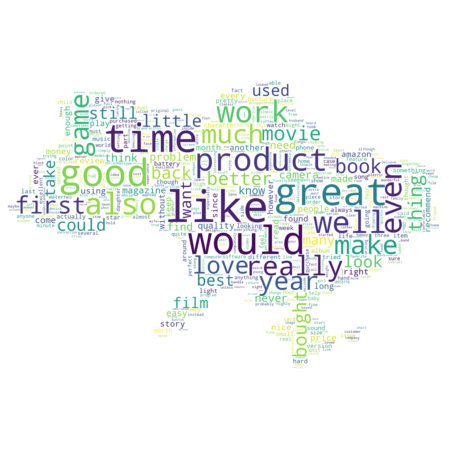

In [37]:
mask = load_mask("https://i.imgur.com/UVe6Nas.png")

wordcloud = WordCloud(
    background_color="white", 
    mask=mask,
    max_words=500,
    random_state=42,
)

wordcloud.generate_from_frequencies(all_words_freq)


plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

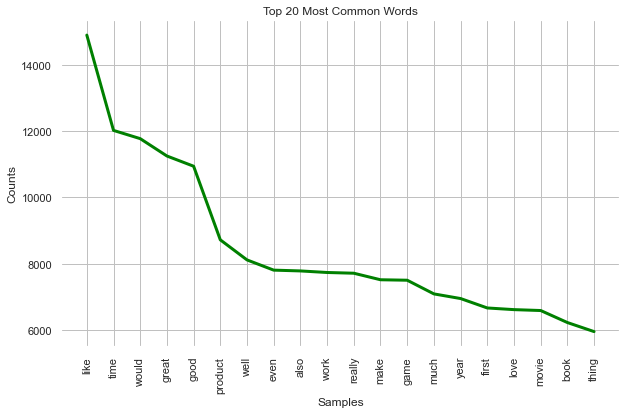

<AxesSubplot:title={'center':'Top 20 Most Common Words'}, xlabel='Samples', ylabel='Counts'>

In [38]:
%matplotlib inline
sns.set()
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('xkcd:white')

all_words_freq.plot(20, color="green", title="Top 20 Most Common Words", linewidth=3)

<h2 align="center">Data Preparation For Training</h2>

We will create our training documents in the form of a tuple. Why tuple? The tuple is immutable, ie they have a fixed size in nature, while the lists are dynamic, they can be changed. Now we don't need to add or remove items, so tuples are a great option, and tuples are faster than lists.

In [39]:
from random import shuffle

def create_doc(reviews, words_list):
    category = list(reviews['Class'])
    docs = [(words_list[word], category[word]) for word in range(len(words_list)) if words_list[word]]
    shuffle(docs)
    return docs

docs = create_doc(reviews, words_list)
print(docs[1], "\n\nNumber of documents:", len(docs))

(['thought', 'purse', 'cute', 'upon', 'receiving', 'disappointed', 'purse', 'black', 'silver', 'buckle', 'stitching', 'gold', 'color', 'well', 'rest', 'purse', 'also', 'tried', 'return', 'able', 'hold', 'anybody', 'help'], 'neg') 

Number of documents: 38544


In next part we also need to work with our data, which we have processed here, so let's `pickle` them.

`pickle`  - module, which implements a powerful algorithm for serializing and deserializing Python objects. "*Pickling*" is the process of converting a Python object to a stream of bytes, and "*unpickling*" is the reverse operation, which converts a stream of bytes back to a Python object. Since a stream of bytes can be easily written to a file, the pickle module is widely used to store and load complex objects in Python.

In [40]:
import pickle

with open("documents.pql", "wb") as ms:   # Pickling
    pickle.dump(docs, ms)

Now we will create a method **`find_matches`** that will return the dictionary with words as key and the presence in our dictionary of most common words (`all_words_freq`) as a value of `True` or `False`, an additional parameter will represent a number of most frequently repeated words we want to use (default - 50).

In [41]:
def find_matches(doc, all_words, num_freq=50):
    word_matches = [word[0] for word in all_words.most_common(num_freq)]
    words = regex_tokenizer(doc)

    matches = {}
    for word in word_matches:
        matches[word] = (word in words)

    return matches

print(find_matches("All is amazing. I never seen anything like this. It's a film that leads you to think about time, about yourself and your problems and plans in your life. This was not good, but awesome.", all_words_freq))

{'like': True, 'time': True, 'would': False, 'great': False, 'good': True, 'product': False, 'well': False, 'even': False, 'also': False, 'work': False, 'really': False, 'make': False, 'game': False, 'much': False, 'year': False, 'first': False, 'love': False, 'movie': False, 'book': False, 'thing': False, 'bought': False, 'better': False, 'little': False, 'back': False, 'could': False, 'still': False, 'look': False, 'best': False, 'used': False, 'take': False, 'want': False, 'film': True, 'many': False, 'problem': False, 'think': True, 'camera': False, 'know': False, 'never': True, 'find': False, 'need': False, 'magazine': False, 'made': False, 'quality': False, 'people': False, 'come': False, 'price': False, 'easy': False, 'read': False, 'review': False, 'money': False}


**`create_matches_set`** creates for each of our documents, which we generated in the **`create_doc`** method, a map of occurrences of popular words in a sentence using the **`find_matches`** method:

In [42]:
def create_matches_set(docs, all_words, num_freq=100):
    matches = []
    for doc, state in docs:
        match = find_matches(' '.join(doc), all_words, num_freq)
        matches.append((match, state))
    return matches

In [43]:
matches_set = create_matches_set(docs[:10], all_words_freq)

print(matches_set[1])

({'like': False, 'time': False, 'would': False, 'great': False, 'good': False, 'product': False, 'well': True, 'even': False, 'also': True, 'work': False, 'really': False, 'make': False, 'game': False, 'much': False, 'year': False, 'first': False, 'love': False, 'movie': False, 'book': False, 'thing': False, 'bought': False, 'better': False, 'little': False, 'back': False, 'could': False, 'still': False, 'look': False, 'best': False, 'used': False, 'take': False, 'want': False, 'film': False, 'many': False, 'problem': False, 'think': False, 'camera': False, 'know': False, 'never': False, 'find': False, 'need': False, 'magazine': False, 'made': False, 'quality': False, 'people': False, 'come': False, 'price': False, 'easy': False, 'read': False, 'review': False, 'money': False, 'every': False, 'month': False, 'another': False, 'give': False, 'play': False, 'right': False, 'using': False, 'since': False, 'recommend': False, 'nice': False, 'however': False, 'found': False, 'long': False, 

<h2 align="center">Test Training</h2>

We will now split the data set in order to perform unbiased model evaluation and identify underfitting or overfitting.

To do this, we will use `scikit-learn` or `sklearn` module. It has many packages for data science and machine learning, but for now we will focus on the `model_selection` package, in particular the `train_test_split()` function.

`train_test_split` - split arrays into random train and test subsets.

In [44]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(matches_set, random_state=42)
print(train_set[1])

({'like': False, 'time': False, 'would': False, 'great': False, 'good': False, 'product': False, 'well': False, 'even': False, 'also': False, 'work': False, 'really': False, 'make': False, 'game': False, 'much': False, 'year': False, 'first': False, 'love': False, 'movie': False, 'book': True, 'thing': False, 'bought': True, 'better': False, 'little': False, 'back': False, 'could': False, 'still': False, 'look': False, 'best': False, 'used': True, 'take': False, 'want': False, 'film': False, 'many': False, 'problem': False, 'think': False, 'camera': False, 'know': False, 'never': False, 'find': False, 'need': False, 'magazine': False, 'made': False, 'quality': False, 'people': False, 'come': False, 'price': False, 'easy': False, 'read': False, 'review': False, 'money': False, 'every': False, 'month': False, 'another': False, 'give': False, 'play': False, 'right': False, 'using': False, 'since': False, 'recommend': False, 'nice': False, 'however': False, 'found': False, 'long': False, '

Now we will save our DataFrame and `matches_set` in csv fortmat, because it took too long to generate, we will use `pickle` for that.

In [45]:
with open("matches_set.pql", "wb") as ms:   # Pickling
    pickle.dump(matches_set, ms)

reviews.to_csv("reviews.csv", sep='\t', encoding='utf-8')

In [46]:
with open("matches_set.pql", "rb") as ms:   # Unpickling
    r = pickle.load(ms)
print(r[2])

({'like': False, 'time': False, 'would': False, 'great': True, 'good': False, 'product': True, 'well': True, 'even': False, 'also': False, 'work': False, 'really': False, 'make': False, 'game': False, 'much': False, 'year': False, 'first': False, 'love': False, 'movie': False, 'book': False, 'thing': False, 'bought': False, 'better': True, 'little': False, 'back': False, 'could': False, 'still': False, 'look': False, 'best': False, 'used': False, 'take': False, 'want': False, 'film': False, 'many': False, 'problem': False, 'think': False, 'camera': False, 'know': False, 'never': False, 'find': False, 'need': False, 'magazine': False, 'made': False, 'quality': False, 'people': False, 'come': False, 'price': False, 'easy': False, 'read': False, 'review': False, 'money': False, 'every': False, 'month': False, 'another': False, 'give': False, 'play': False, 'right': True, 'using': False, 'since': False, 'recommend': False, 'nice': False, 'however': False, 'found': False, 'long': False, 'en

<h2 align="center">Classifier Creation (Naive Bayes Classification)</h2>

Let's use a quick approach to Naive Bayesian classification to see if our pre-processing data can give us good results to continue further more complex models. To begin with, let's expand our `matches_set` to process all reviews (may take some time):

In [56]:
matches_set = create_matches_set(docs, all_words_freq, 2500)

Good, now train and test it:

In [57]:
train_set, test_set = train_test_split(matches_set, test_size=0.33, random_state=42)
print("Length of Matches Set:", len(matches_set), "\nLength of Train Set:", len(train_set))

Length of Matches Set: 38544 
Length of Train Set: 25824


Now we will finally use Naive Bayes Classification and see what accuracy in our model, and what are the most informative features in it:

In [58]:
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier

def naive_bayes_model(train_set, test_set):
    classifier = NaiveBayesClassifier.train(train_set) 
    informative = classifier.show_most_informative_features(10)
    accuracy = nltk.classify.accuracy(classifier, test_set) * 100
    return classifier, informative, accuracy

In [59]:
classifier, informative, accuracy = naive_bayes_model(train_set, test_set)
print(informative)
print("\nClassifier Accuracy:", str(round(accuracy, 2)) + "%") # predict

Most Informative Features
                  refund = True              neg : pos    =     25.4 : 1.0
               delicious = True              pos : neg    =     12.9 : 1.0
                   waste = True              neg : pos    =     11.7 : 1.0
                   worst = True              neg : pos    =     11.5 : 1.0
               worthless = True              neg : pos    =     11.4 : 1.0
                 cheaply = True              neg : pos    =     10.4 : 1.0
              refreshing = True              pos : neg    =      9.6 : 1.0
               contacted = True              neg : pos    =      9.5 : 1.0
                horrible = True              neg : pos    =      9.3 : 1.0
                 garbage = True              neg : pos    =      9.3 : 1.0
None

Classifier Accuracy: 81.26%


We have 80-85% accuracy in our classifier, which is a good sign to move on!

<h2 align="center">Testing Classifier</h2>

To properly test our input sentence, it must go through all stages of processing - tokenize, lemmatize and stop_words, irrelevant_words elimination. Let's write a method:

In [60]:
def words_preparation(sent):
    words = regex_tokenizer(sent)                    # remove punctuation
    words = stopwords_elimination(STOP_WORDS, words) # eliminate stopwords
    words = lemmatize_words(words)                   # lemmatizing
    words = irr_words_elim(words)                    # irrelevent words elimination
    print("Sentence after processing:", words)
    return " ".join(words)

And test it:

In [61]:
test_sent = "One of the best films of all time, an absolute masterpiece. The Godfather is arguably the best gangster drama as well as setting the standard for cinema."
print("Test sentence:", test_sent)

test_sent = find_matches(words_preparation(test_sent), all_words_freq, 2500)
classifier.classify(test_sent)

Test sentence: One of the best films of all time, an absolute masterpiece. The Godfather is arguably the best gangster drama as well as setting the standard for cinema.
Sentence after processing: ['best', 'film', 'time', 'absolute', 'masterpiece', 'godfather', 'arguably', 'best', 'gangster', 'drama', 'well', 'setting', 'standard', 'cinema']


'pos'

The first test is passed, let's use less obvious words:

In [62]:
test_sent = "This book is quite readable .."
print("Test sentence:", test_sent)

test_sent = find_matches(words_preparation(test_sent), all_words_freq, 2500)
classifier.classify(test_sent)

Test sentence: This book is quite readable ..
Sentence after processing: ['book', 'quite', 'readable']


'pos'

And here everything is correct. Let's check the sentences with a negative mood:

In [63]:
test_sent = "The most entertaining part of this entire movie was reading these hilariously bad reviews. It was SO boring and hard to watch."
print("Test sentence:", test_sent)

test_sent = find_matches(words_preparation(test_sent), all_words_freq, 2500)
classifier.classify(test_sent)

Test sentence: The most entertaining part of this entire movie was reading these hilariously bad reviews. It was SO boring and hard to watch.
Sentence after processing: ['entertaining', 'part', 'entire', 'movie', 'reading', 'hilariously', 'review', 'boring', 'hard', 'watch']


'neg'

Working! That's all here, next we will try to apply a different approach than this naive way, we will use another classifiers and LSTM, which takes into account the order of words in the sentence to get better accuracy.